## StarCraft Player Analysis

### Import Libraries

In [2]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegressioxan
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost
from imblearn.over_sampling import RandomOverSampler, SMOTE


from keras import layers, datasets, models
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow as tf

### Import data

In [45]:
# Please ensure to provide the right location of the csv file when running the code
data = pd.read_csv("starcraft_player_data.csv")
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


## EDA

In [159]:
data.tail()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
3394,10095,8,?,?,?,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


As shown above, Age, HoursPerWeek and TotalHours have some missing values. Upon detailed inspection, it was found that all of the missing values correspond to players from LeagueIndex 8. We cant delete these values as we would then remove all the data points corresponding to LeagueIndex 8. However, we have data for all the other columns and we can use a basic Linear Regression model to impute these missing values.

### Impute Missing Values

In [46]:
# As described above, the below function imputes missing values using Linear Regression
def impute_missing_values_LinReg(data, col):
    missing_cols = ["Age", "HoursPerWeek", "TotalHours"]
    lr = LinearRegression()
    train = data.loc[data[col]!="?"]
    test = data.loc[data[col]=="?"]
    lr.fit(train.drop(missing_cols,axis=1), train[col])
    pred = lr.predict(test.drop(missing_cols, axis=1))
    data.loc[data[col]=="?", col] = pred
    data.loc[:,col]= data.loc[:,col].astype(int)

In [47]:
# Calling the function and modifying the dataset - data
impute_missing_values_LinReg(data, "Age")
impute_missing_values_LinReg(data, "HoursPerWeek")
impute_missing_values_LinReg(data, "TotalHours")

In [95]:
# Missing values have been imputed
# The correctness of these missing values can be seen under data visualization
data.tail()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3390,10089,8,22,25,6434,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,20,27,7941,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,20,27,7976,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,18,32,10197,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
3394,10095,8,17,30,8646,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


### Data Visualization

In [40]:
data.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

In [48]:
# Function to plot the Median metric by LeagueIndex
# Mean is used for a couple of metrics like ComplexUnitsMade, ComplexAbilitiesUsed as its median is 0
def plot_med_by_LeagInd(data, col, ax=None):
    if col not in ["ComplexUnitsMade", "ComplexAbilitiesUsed"]:
        gdf1 = data.groupby("LeagueIndex")[col].median().reset_index()
    else:
        gdf1 = data.groupby("LeagueIndex")[col].mean().reset_index()
    sns.barplot(gdf1, x="LeagueIndex", y=col, ax=ax)

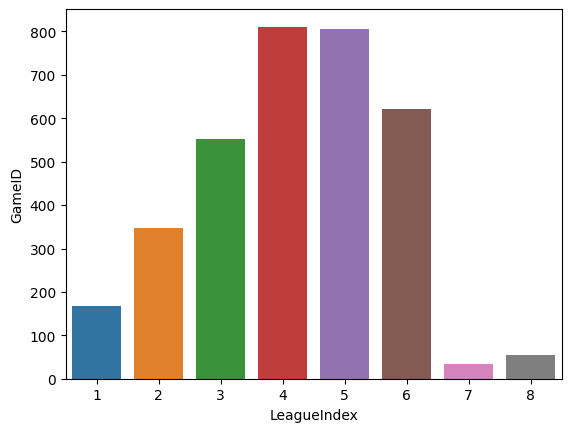

In [49]:
# Distribution of data points over LeagueIndex
df1 = data.groupby("LeagueIndex")["GameID"].count().reset_index()
sns.barplot(df1, x="LeagueIndex", y="GameID")
plt.show()

The above graph shows the number of available data points by the response variable (LeagueIndex). As you can see, LeagueIndex 7 & 8 have very few data points whereas 4 & 5 have the most number of data points. This type of distribution is seen in most multiplayer online games where the ranks in the middle leagues have the most players.

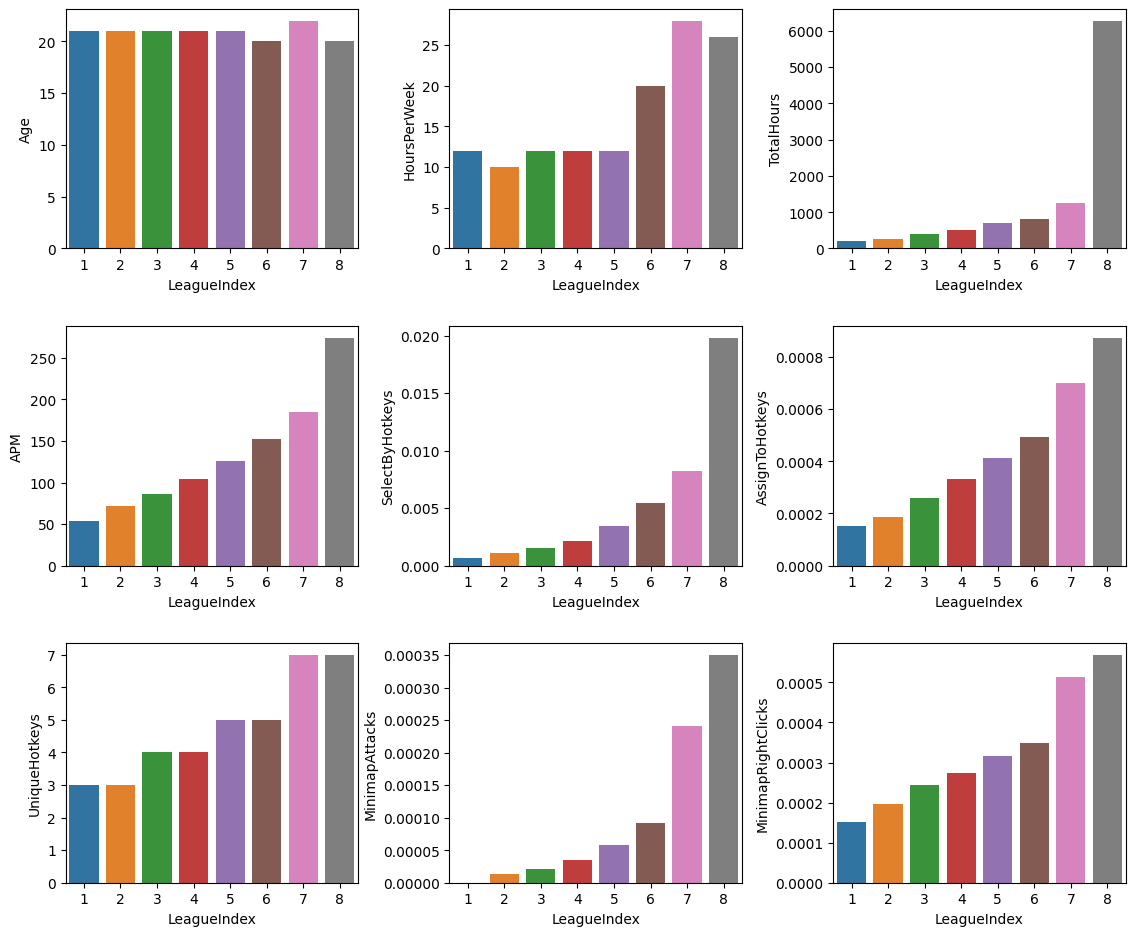

In [50]:
# Median of metrics by LeagueIndex
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
axes = ax.flatten()
cols = data.columns[2:]
fig.tight_layout(pad=3.5)
for i in range(len(axes)):
    plot_med_by_LeagInd(data, cols[i], axes[i])


Typically, the amount of time spent gaming would be directly proportional to the League rankings (with some exceptions). 
Here are a few observations based on median values we can draw from the plots above:
- Age is inversely proportional to LeagueIndex. This is true because Starcraft like other competitive e-sports require quick reflexes and it caps at around 24. The reflexes and muscle memory develop much better at a younger age
- In order to stay in touch with the game, it is important to keep in touch. This would mean spending enough hours on the game every day. HoursPerWeek gives us this information and it increases with higher leagues. Typically, Pro gamers spend almost 8 hours a day
- TotalHours tells you how much experience the player has playing the game and it is directly proportional to being in higher leagues. TotalHours for league 5 does not appear to fall in line and it is discussed in the upcoming sections
- Starcraft is a multitasking game and all about managing the macro - keeping up a stead rate of income, expansions, proper buildings & upgrades. Being able to perform multiple actions in a short time is important and players capable of handling this will be found in higher leagues. APM (Actions per minute) shown in the above graph correlates to this
- Using Hotkeys is vital in keeping up with the pace of the game. The time spent in moving the cursor to click and perform an action is much higher than tapping a couple of keys in the keyboard to perform the same action. Features SelectByHotkeys, AssignToHotkeys and UniqueHotkeys give this information and show that players in higher leagues use more hotkeys
- Similar to using hotkeys, clicking on the minimap takes you to a location directly, rather than scrolling and reaching to it. This also saves a lot of time and players in higher leagues will have features such as MinimapAttacks and MinimapRightClicks higher than players in lower leagues


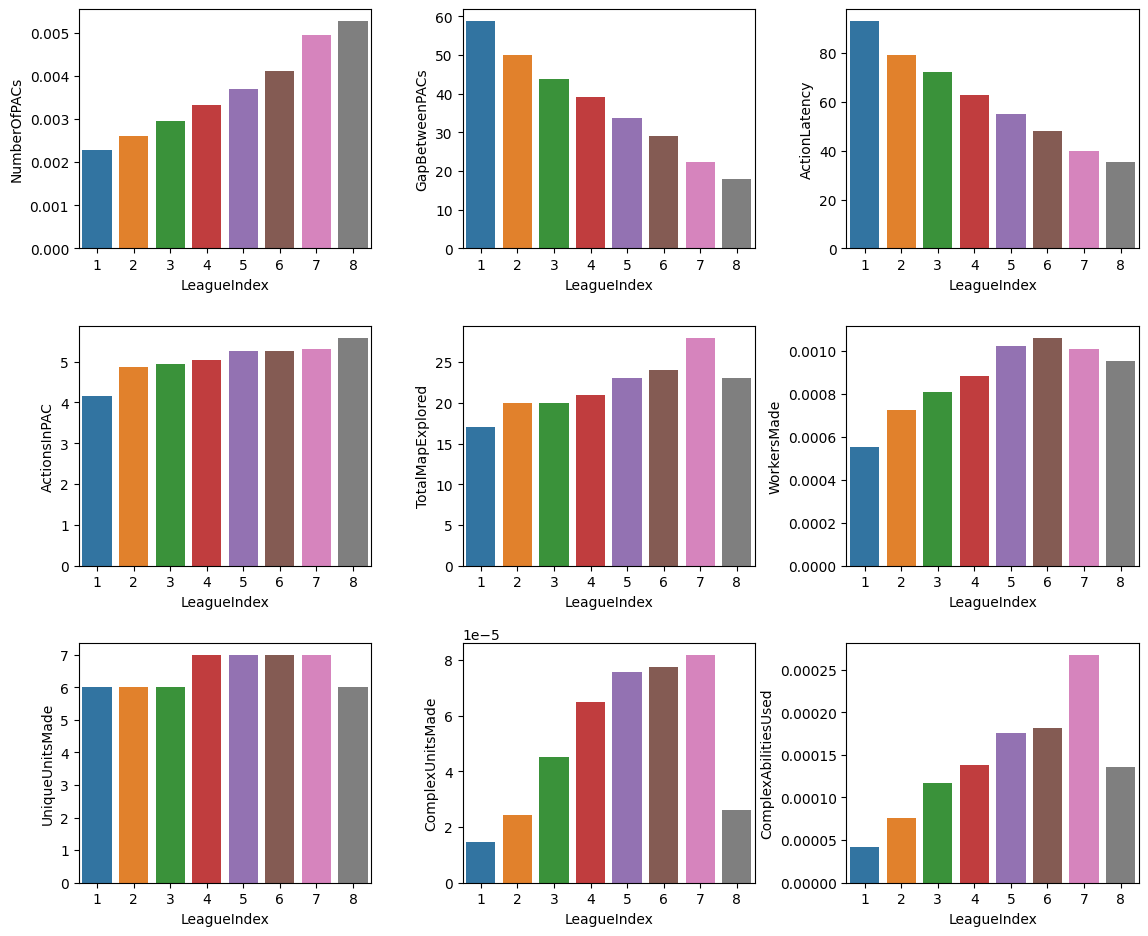

In [51]:
# Median of metrics by LeagueIndex
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
axes = ax.flatten()
cols = list(data.columns[2+9:])
fig.tight_layout(pad=3.5)
for i in range(len(cols)):
    plot_med_by_LeagInd(data, cols[i], axes[i])


- A PAC is a shift in the display screen to another location and performing an action there. Being a multitasking game, it requires handling workers at the multiple command centers, moving the army units elsewhere, kiting and scouting. Performing all these actions simultaneously will greatly improve the game of any player. Features like NumberOfPACs, GapBetweenPACs. ActionsInPAC all relate to this. An ideal player should have low GapBetweenPACs, high NumberOfPACs and maintain low ActionLatency between these actions. 
- Exploring map is vital to the game to understand where enemies have setup new bases. Typically most of the map is covered in fog of war (player's units do not have vision), but exploring the map will reveal new enemy bases even though the vision may not be persistent. Exploration is key to playing at a higher level and we can see that in the graph as well. One reason TotalMapExplored could be lower for professional league players is because at that level they have a really good knack of understanding what the opponent would be doing and they can predict to a good extent their movements. So they don't really need to waste time exploring and instead put that time and effort in building a better economy.
- Having the ability to effectively use diverse unit types is crucial for achieving success in gameplay. Metrics such as WorkersMade, UniqueUnitsMade, ComplexUnitsMade and ComplexAbilitiesUsed demonstrate this pattern, where higher-level players exhibit higher values in these metrics. Specifically for ComplexUnitsMade and ComplexAbilitiesUsed, League 8 players have lower values and this needs to be inspected further for clarification


**To Summarize on the above features, they all have a clear trend w.r.t. LeagueIndex and they can all be used in predicting the response variable**

In [52]:
# GameID is not required
data = data.drop("GameID", axis=1)

### Remove Outliers

Capping the values to 1 and 99 percentile is a great way to remove outliers

In [53]:
for col in data.columns:
    low, high = data.loc[:,col].quantile([0.01,0.99])
    data.loc[:,col] = data.loc[:,col].clip(low,high)

As you can see above, the TotalHours now follows the required trend after remvoing the outliers. Seems like LeagueIndex 5 had an outlier that was affecting its mean.

### Feature Engineering

Correlation is the degree of association between features, ie, how much does a feature vary compared to another feature. Correlation between features is a nuisance when it comes to modeling (for linear models). This is because the linear models like logistic regression, try to assign coefficients to different features. When the features are correlated, it is confused on what coefficients to assign as correlated features would provide the same kind of information in predicting the response. Hence removing highly correlated variables (Pearsons correlation > 0.5) is necessary

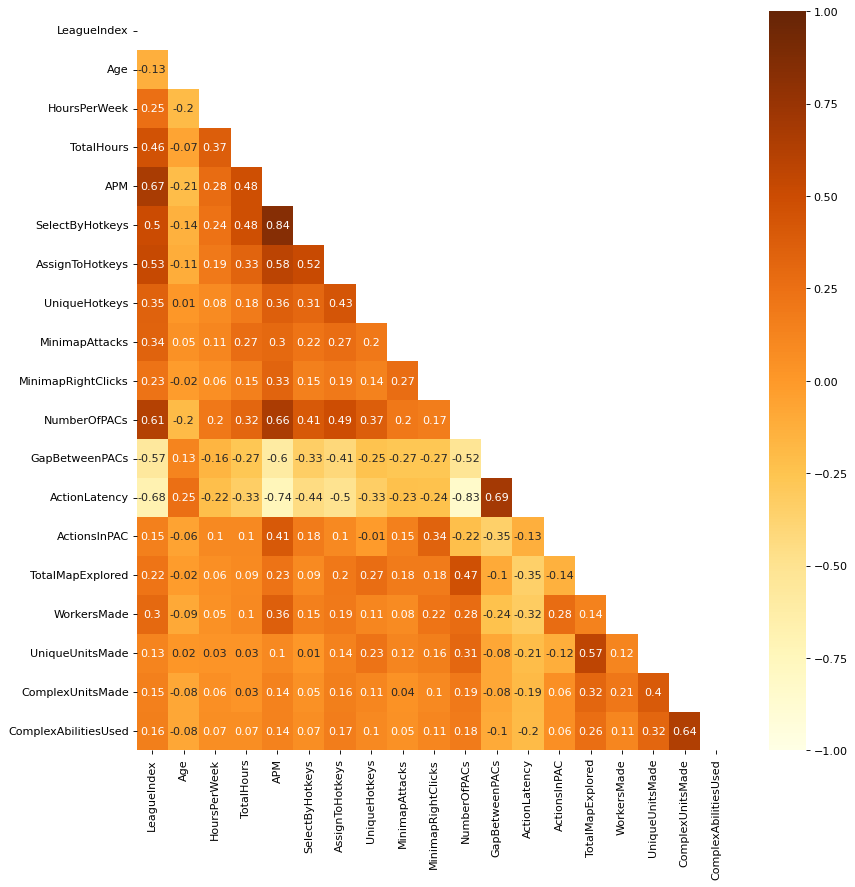

In [55]:
# Plotting correlation
mat = data.corr(method='pearson').round(2)
plt.figure(figsize=(12, 12), dpi=80)
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(mat, cmap="YlOrBr", annot=True, mask=mask, vmin=-1, vmax=1)
plt.show()

In [56]:
# Drop highly correlated columns
drop_cols = ["SelectByHotkeys", "NumberOfPACs", "GapBetweenPACs", "ActionLatency",
            "AssignToHotkeys", "ComplexUnitsMade"
            ]
data = data.drop(drop_cols, axis=1)

## Modelling

Mulitple machine learning models are tested on the data to find the model with best accuracy. 

### Test Train Split

Splitting the Dataset by 80% training and 20% test. Models are built on 80% data and then tested on 20% data. 

In [57]:
y = "LeagueIndex"

In [58]:
train, test = train_test_split(data, test_size=0.2, random_state=50, stratify=data[y])
X_train = train.drop(y, axis=1)
y_train = train[y]
X_test = test.drop(y, axis=1)
y_test = test[y]

### Scaling

Scaling is important for linear models because they use a linear combination of features in some capacity to predict the response. Hence, if the features are in different scales, there is possibility that some features could dominate or the model might take longer to converge on the right set of weights. A MinMax scaler is used here.

In [59]:
scaler = MinMaxScaler()
scaler_model = scaler.fit(X_train)
scaled_data = scaler_model.transform(X_train)
X_train = pd.DataFrame(scaled_data, columns=X_train.columns)
X_train.head()

,Age,HoursPerWeek,TotalHours,APM,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexAbilitiesUsed
0,0.315789,0.740741,0.474814,0.709078,1.0,0.651499,0.456057,0.385904,0.513406,0.218410,0.250,0.0
1,0.157895,0.259259,0.111909,0.577205,0.5,0.299790,0.198410,0.756670,0.342270,0.192974,0.000,0.0
2,0.368421,0.518519,0.515901,0.593024,0.6,0.000000,0.020329,0.454362,0.513406,0.136133,0.375,0.0
3,0.210526,0.185185,0.043165,0.471552,0.5,0.047892,0.194840,0.243703,0.513406,0.180954,0.500,0.0
4,0.315789,0.259259,0.107113,0.232721,0.5,0.395122,0.175716,0.181342,0.285225,0.167614,0.625,0.0


In [60]:
# Scaling test data
scaler_model_test = scaler.fit(X_test)
scaled_data_test = scaler_model_test.transform(X_test)
X_test = pd.DataFrame(scaled_data_test, columns=X_test.columns)
X_test.head()

,Age,HoursPerWeek,TotalHours,APM,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexAbilitiesUsed
0,0.315789,0.074074,0.051158,0.162239,0.6,0.029013,0.149094,0.472512,0.114090,0.186131,0.250,0.000000
1,0.105263,0.074074,0.123100,0.384444,0.2,0.078200,0.078140,0.604873,0.114090,0.154914,0.125,0.000000
2,0.000000,0.074074,0.027178,0.213392,0.5,0.033790,0.368990,0.517094,0.541928,0.399962,0.500,0.227875
3,0.315789,0.222222,0.196640,0.047096,0.5,0.000000,0.022707,0.007983,0.399315,0.043960,0.375,0.059599
4,0.000000,0.333333,0.155074,0.203298,0.4,0.016290,0.076738,0.076784,0.484883,0.274699,0.375,0.209257


Below are different models with their training and testing errors

### Logistic Regression

In [61]:
# Fitting the Logistic regression model
logreg = LogisticRegression(multi_class='multinomial', 
                           solver='saga', 
                           max_iter=2000, 
                           penalty='elasticnet', 
                           l1_ratio=0.1,
                          class_weight= "balanced")
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', l1_ratio=0.1, max_iter=2000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')

In [62]:
# Predict
yhat_logit_train = logreg.predict(X_train)
print("training error: ", accuracy_score(y_train, yhat_logit_train))

yhat_logit = logreg.predict(X_test)
print("testing error: ", accuracy_score(y_test, yhat_logit))



training error:  0.30412371134020616
testing error:  0.32989690721649484


### Random Forests (Bagging)

In [68]:
# Hyperparameter tuning is performed using Grid Search to find the best parameters for the model
param_grid = {"criterion": ['gini', 'entropy'],
             "n_estimators": [20, 40, 60, 80, 100, 200],
              "min_samples_leaf": [20, 40],
              "max_depth": [3,5,7],
                "max_features": [None, 'auto'],
              "class_weight": ["balanced", None]
              }
rf = RandomForestClassifier(n_jobs=4, max_features=None)
gs = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=4)
gs.fit(X_train, y_train)
gs.best_params_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'n_estimators': 20}

In [69]:
# Fitting the Random Forest Classifier
rf = RandomForestClassifier(max_depth=7, 
                            random_state=4, 
                            min_samples_leaf=20, 
                            n_jobs=4,
                            n_estimators=20,
                            criterion='entropy',
                            max_features= 'auto',
                           class_weight= "balanced" # Using Balanced instead of None as it gives lesser Variance
                           )
rf.fit(X_train.values, y_train.values)

yhat_rf_train = rf.predict(X_train.values)
print("Training Error: ", accuracy_score(y_train, yhat_rf_train))

yhat_rf = rf.predict(X_test.values)
print("Testing Error: ", accuracy_score(y_test, yhat_rf))

Training Error:  0.4583946980854197
Testing Error:  0.36671575846833576


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


### XGBoost (Boosting)

In [70]:
# XGB Classifier requires response to be in range of 0,...,k-1, where k is the number of classes
xgb_y_train = y_train-1
xgb_y_test = y_test-1

In [71]:
# Hyperparameter tuning is performed using Grid Search to find the best parameters for the model
xgb = xgboost.XGBClassifier(objective='multiclass', eval_metric='mlogloss')
param_grid = {"learning_rate": [0.01,0.05, 0.1],
             "n_estimators": [30, 50, 70, 100, 200],
              "max_depth": [3,5,7]
              }
gs = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=4)
gs.fit(X_train, xgb_y_train)
gs.best_params_


Fitting 3 folds for each of 45 candidates, totalling 135 fits


{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}

In [94]:
# Fitting the Random Forest Classifier
xgb = xgboost.XGBClassifier(objective='multiclass', eval_metric='mlogloss', n_jobs=4, random_state=4,
                            # Best parameters not used due to high variance
                           learning_rate=0.01,
                            max_depth=3,
                            n_estimators=20
                           )
xgb.fit(X_train, xgb_y_train)

yhat_xgb_train = xgb.predict(X_train)
print("Training Error:", accuracy_score(xgb_y_train, yhat_xgb_train))

yhat_xgb = xgb.predict(X_test)
print("Testing Error: ", accuracy_score(xgb_y_test, yhat_xgb))


Training Error: 0.39801178203240056
Testing Error:  0.3711340206185567


### LightGBM

In [78]:
# Fitting the LightGBM model
lgbm = LGBMClassifier(objective='multiclass', random_state=5, n_jobs=4)
lgbm.fit(X_train, y_train)

yhat_lgbm_train = lgbm.predict(X_train.values)
print("Training Error: ", accuracy_score(y_train, yhat_lgbm_train))

yhat_lgbm = lgbm.predict(X_test.values)
print("Testing Error: ", accuracy_score(y_test, yhat_lgbm))

Training Error:  1.0
Testing Error:  0.4050073637702504


### Neural Networks - Multilayer Perceptron

In [79]:
# Creating a validation set from the training set
# Validation set is used to determine the best stopping point while training any neural network
# This is done mainly to prevent overfitting

X_train_nn, X_val_nn, y_train_nn , y_val_nn = train_test_split(X_train, y_train, test_size=y_test.shape[0], random_state=50, stratify=y_train)
y_train_nn = to_categorical(y_train_nn-1)
y_val_nn = to_categorical(y_val_nn-1)
y_test_nn = to_categorical(y_test-1)
print(X_train_nn.shape)
print(X_val_nn.shape)
print(X_test.shape)

print(y_train_nn.shape)
print(y_val_nn.shape)
print(y_test_nn.shape)

(2037, 12)
(679, 12)
(679, 12)
(2037, 8)
(679, 8)
(679, 8)


In [88]:
# Define parameters
epochs = 200
batch_size = X_train_nn.shape[0]
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
#opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
metric = 'accuracy'
activation_fn = 'relu'

In [89]:
# Build the network
start = layers.Input(shape=X_train_nn.shape[1])
model = layers.Dense(128, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(start)
model = layers.Dense(64, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.Dense(16, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
out = layers.Dense(8, activation='softmax')(model)
nn = Model(inputs=start, outputs=out)

In [90]:
# Fitting the Neural Network model
nn.compile(loss=loss, optimizer=opt, metrics=metric)
nn.fit(X_train_nn, y_train_nn, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nn, y_val_nn), verbose=0)

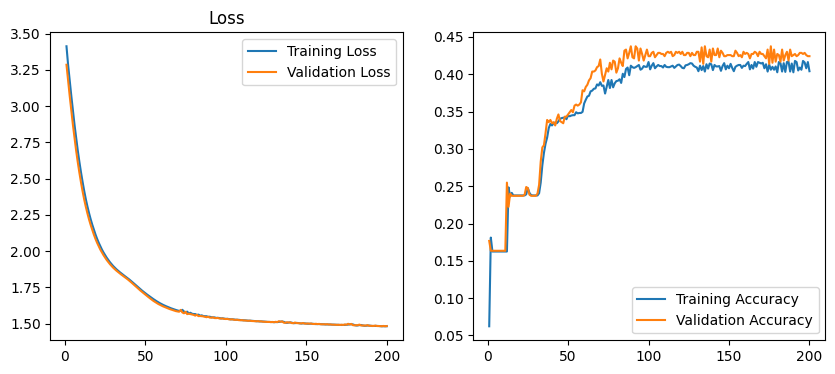

In [91]:
# Plot the losses and accuracy
hist_res = nn.history.history
acc = hist_res['accuracy']
val_acc = hist_res['val_accuracy']
loss = hist_res['loss']
val_loss = hist_res['val_loss']

epochs_list=range(1, len(loss)+1)

fig, ax = plt.subplots(1,2, figsize = (10,4))
sns.lineplot(x=epochs_list, y=loss, ax=ax[0], legend='brief', label="Training Loss")
sns.lineplot(x=epochs_list, y=val_loss, ax=ax[0], legend='brief', label="Validation Loss")
ax[0].set_title("Loss")

sns.lineplot(x=epochs_list, y=acc, ax=ax[1], legend='brief', label="Training Accuracy")
sns.lineplot(x=epochs_list, y=val_acc, ax=ax[1], legend='brief', label="Validation Accuracy")
ax[1].legend()
plt.show()

Based the above graph, 120 epochs is a good stopping point (Please note results might slightly vary with different iterations)

In [92]:
# Retrain the network for 120 epochs and print the results
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
start = layers.Input(shape=X_train_nn.shape[1])
model = layers.Dense(128, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(start)
model = layers.Dense(64, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.Dense(16, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
out = layers.Dense(8, activation='softmax')(model)
nn = Model(inputs=start, outputs=out)

nn.compile(loss=loss, optimizer=opt, metrics=metric)
nn.fit(X_train_nn, y_train_nn, epochs=120, batch_size=batch_size, validation_data=(X_val_nn, y_val_nn), verbose=0)



In [93]:
yhat_nn_train = nn.predict(X_train_nn.values)
yhat_nn_train = np.argmax(yhat_nn_train, axis=1)
y_train_nn1 = np.argmax(y_train_nn, axis=1)
print("Training Error: ", accuracy_score(y_train_nn1, yhat_nn_train))

yhat_nn_val = nn.predict(X_val_nn.values)
yhat_nn_val = np.argmax(yhat_nn_val, axis=1)
y_val_nn1 = np.argmax(y_val_nn, axis=1)
print("Training Error: ", accuracy_score(y_val_nn1, yhat_nn_val))

yhat_nn = nn.predict(X_test)
yhat_nn = np.argmax(yhat_nn, axis=1)
print("Testing Error: ", accuracy_score(y_test, yhat_nn))

Training Error:  0.39813451153657337
Training Error:  0.4182621502209131
Testing Error:  0.29013254786450665


### Best model to use

In [95]:
training_errors = [0.304, 0.3980, 0.4182, 1, 0.3981]
testing_errors = [0.329, 0.3711, 0.3888, 0.3858, 0.2901]
cols = ["Logistic Regression", "Random Forests", "XGBoost", "LightGBM", "MLP"]
results = pd.DataFrame(cols, columns=["Model"])
results["training_errors"] = training_errors
results["testing_errors"] = testing_errors
results["training_errors"] = results["training_errors"]*100
results["testing_errors"] = results["testing_errors"]*100
results

,Model,training_errors,testing_errors
0,Logistic Regression,30.40,32.90
1,Random Forests,39.80,37.11
2,XGBoost,41.82,38.88
3,LightGBM,100.00,38.58
4,MLP,39.81,29.01


**XGBoost gave the best results with 41% training error and 38% testing error and it is used as the final model**. Neural Networks (MLP) had a very low testing error and hence it is not used as the final model. Random Forests and Logistic regression had lower accuracy compared to XGBoost. LightGBM has similar testing accuracy but very high variance and hence it is disregarded

### Variable Importance

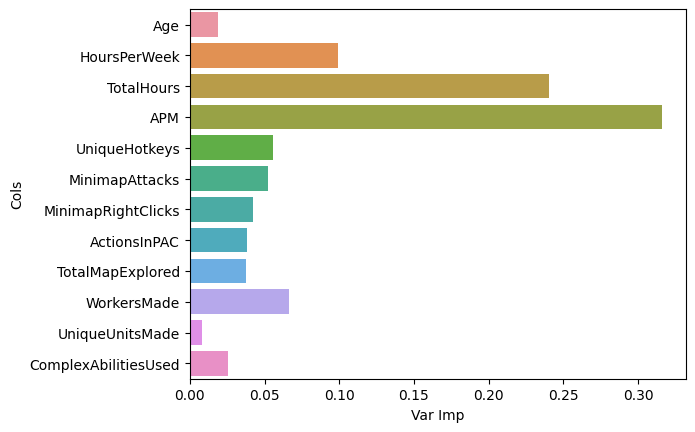

In [96]:
feat_imp = pd.DataFrame(rf.feature_importances_, columns=["Var Imp"])
feat_imp["Cols"] = X_train.columns
sns.barplot(feat_imp, x="Var Imp", y="Cols")
plt.show()

**APM and TotalHours are 2 very important features in determining the LeagueIndex**

### Confusion Matrix

Confusion Matrix with Actual LeagueIndex along the row & Predicted LeagueIndex along the columns

In [97]:
conf = confusion_matrix(y_test, yhat_xgb+1)
conf = pd.DataFrame(conf)
conf.columns = range(1,9)
conf.index = range(1,9)
print("Confusion Matrix with Actual LeagueIndex along the row & Predicted LeagueIndex along the columns")
conf

Confusion Matrix with Actual LeagueIndex along the row & Predicted LeagueIndex along the columns


,1,2,3,4,5,6,7,8
1,11,15,3,2,2,0,0,0
2,3,21,6,21,17,2,0,0
3,3,14,3,34,55,2,0,0
4,1,14,4,36,81,24,0,2
5,0,0,0,11,90,57,0,3
6,0,0,0,2,41,81,0,0
7,0,0,0,0,1,6,0,0
8,0,0,0,0,0,1,0,10


We can see that predicting LeagueIndex for 4,5,6 has the highest error rate. It is possible that more data can help with better accuracy in these leagues

### Conclusion - to non technical stakeholders

- The number of hours spent in playing the game is directly proportional to higher league rankings. Players are advised to put in enough effort on a daily basis to gain the required skills and experience for the game
- Starcraft is a multitasking game and it is important to manage the macro in the game. Features such as APM, NumberOfPACs, GapBetweenPACs, ActionsInPAC relate to this and an ideal player should have low GapBetweenPACs, high NumberOfPACs and maintain low ActionLatency between these actions. Players should strive to perform multiple actions within a short span to improve their game
- Micro management is also important as it involves effective movement and skill utilization of different units without taking too much time. Features such as MinimapRightClicks, SelectByHotkeys, AssignToHotkeys and UniqueHotkeys give a good  indication on these metrics and how it relates to players from higher leagues
- Having the ability to effectively use diverse unit types is crucial for achieving success in gameplay. Metrics such as WorkersMade, UniqueUnitsMade, ComplexUnitsMade, and ComplexAbilitiesUsed demonstrate this pattern, where higher-level players exhibit higher values in these metrics
- Higher usage of Minimap and Hotkeys is encouraged as it reduces the time taken to perform these actions
- The accuracy with which we can predict a player's League index is currently 38%. Based on the confusion matrix, we can see that predicting LeagueIndex for 4,5,6 has the highest error rate. It is possible that more data can help with better accuracy in these leagues. Also, the variables APM and TotalHours are key predictors. 


### If we were to collect more data?

- We need to first define the problem at hand as we might require additional features based on the problem
- Ensure that the features Age, HoursPerWeek and TotalHours are also collected. These features are important in predicting the LeagueIndex of the players
- It would help to prioritize data collection where available data is less (For example, Leagues 7 & 8 have very few data points)
- It would help to analyze players data at different points in time to see how the player grows and how each feature changes as the player progresses in different leagues
- Ensure that data is not restricted to one region. Different regions tend to have different play styles and features might differ based on region. It would be great to have this as a feature as well

## Appendix

### Resampling - (not used, only for reference)

The model generally learns best when there are enough data points in each category of LeagueIndex. This is because the model tends to learn better on what is abundantly available. Considering we had some categories with very few data points, Resampling was tested to see if it helps. It helped to some extent in improving the bias (lower training dataset error), but the variance was high (higher testing dataset error). Hence, resampling was not used